### Load dataframe

In [1]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig

In [4]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [5]:
DATASET_ID = "git_repos"

In [6]:
DT_ID = '2022-03-04_18-41-29'

In [7]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'segment_df_for_umap.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,filename,group,location,sex,wav_loc,key,rate,specs,call_lab_simp,combi_lab_simp
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH


In [8]:
seg_df.sort_values(by=['ID'], inplace=True)

In [9]:
len(seg_df.combi_unique_num.unique())

222

In [10]:
len(seg_df)

1333

In [11]:
len(seg_df.call_unique_num.unique())

561

### Spectrograms for all individuals

In [12]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [13]:
seg_df = seg_df[np.array([np.sum(i) > 0.0 for i in seg_df.specs.values])
]

In [14]:
specs = list(seg_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/1333 [00:00<?, ?it/s]

(1333, 4096)

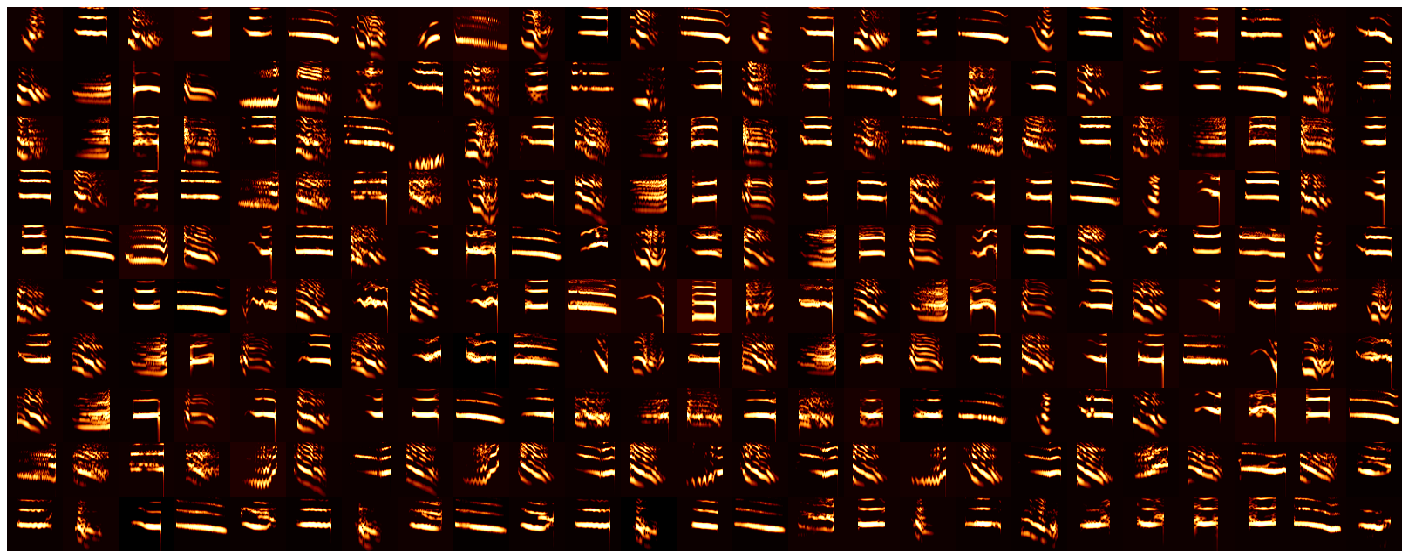

In [15]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [16]:
fit = umap.UMAP(min_dist=0.0, verbose = True)
z = list(fit.fit_transform(specs_flattened))

UMAP(min_dist=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Sep 11 12:30:08 2022 Finding Nearest Neighbors
Sun Sep 11 12:30:09 2022 Finished Nearest Neighbor Search
Sun Sep 11 12:30:11 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Sep 11 12:30:13 2022 Finished embedding


In [17]:
seg_df['umap'] = list(z)

In [ ]:
nex = -1
scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=12,
    #x_range = [-14,14],
    #y_range = [-14,15],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(15, 15),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.labels.values,
        'alpha':1,
        's': 8,
        'show_legend': True,
        "color_palette": 'tab10',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=False,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [19]:
#save df
save_loc = DATA_DIR / DATASET_ID / DT_ID /  'segment_umap.pickle'
ensure_dir(save_loc.as_posix())
seg_df.to_pickle(save_loc)

Two segment classes have much smaller counts compared to the four other classes (HL & US; N < 30), as such, these likely reflect mistakes during the labelling process and actually belong to one of the four larger clusters. We will check this in the next notebook.